In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torchtext
import torch
import numpy as np
from random import sample
from torch.autograd import Variable


In [2]:
print(torch.__version__)

1.0.1.post2


In [3]:

DATA_FILE = '/home/ubuntu/data/names'

import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [4]:

pad_token = '#'
names = []
with open(DATA_FILE) as f:
    names = f.read().split('\n')[:-1]

MAX_LEN = max(map(len, names))
    
tokens = set()
for name in names:
    for token in name:
        tokens.add(token)

tokens.add(pad_token)

tokens_ids = {}
ids_tokens = {}
for ind,token in enumerate(tokens):
    tokens_ids[token] = ind
    ids_tokens[ind] = token


In [5]:

def to_nums(name):
    return [tokens_ids[ch] for ch in name]

def to_word(ids):
    return ''.join([ids_tokens[id] for id in ids])

def to_pad(nums):
    pad_arr = [tokens_ids[pad_token] for _ in range(MAX_LEN-len(nums))]
    return nums + pad_arr


def sample_names(batch_size=32):
    return sample(names, batch_size)


def to_matrix(names):
    return np.array([to_pad(to_nums(name)) for name in names])

to_matrix(sample_names(batch_size=3))

array([[54, 43,  1,  1, 47, 29,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [49, 17, 29, 25, 47, 32,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [49, 17,  1, 24, 39, 55,  2,  2,  2,  2,  2,  2,  2,  2,  2]])

In [6]:

import torch.nn as nn

class SimpleRNN(torch.nn.Module):
    def __init__(self, n_input, n_hidden, n_output):
        super(SimpleRNN, self).__init__()
        self.n_hidden = n_hidden
        
        self.i2h = nn.Linear(n_input + n_hidden, n_hidden)
        self.h2o = nn.Linear(n_hidden, n_output)
        self.softmax = nn.LogSoftmax(dim=1)
#         self.softmax = nn.Softmax(dim=1)
        self.relu = nn.ReLU()
        

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        next_hidden = self.i2h(combined)
        next_hidden = self.relu(next_hidden)
        output = self.h2o(next_hidden)
        return next_hidden, self.softmax(output)
    
    def initHidden(self):
        return torch.zeros(1, self.n_hidden)



In [7]:

t1 = torch.zeros(3,2,10)
t2 = torch.zeros(3,2,20)

torch.cat((t1,t2),2).shape


torch.Size([3, 2, 30])

In [8]:

n_letters = len(tokens)

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][tokens_ids[letter]] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [tokens_ids[line[li]] for li in range(1, len(line))]
    letter_indexes.append(tokens_ids[pad_token]) # EOS
    return torch.LongTensor(letter_indexes)


def sample_one():
    name = sample(names, 1)[0]
    input_line_tensor = inputTensor(name)
    target_line_tensor = targetTensor(name)
    return input_line_tensor, target_line_tensor



In [9]:

rnn = SimpleRNN(n_letters, 128, n_letters)

hidden = rnn.initHidden()
input = inputTensor(names[0]) # first letter

print(input.size(0))

next_hidden, output = rnn(input[0], hidden)
print(next_hidden.shape, output.shape)


7
torch.Size([1, 128]) torch.Size([1, 56])


In [10]:

criterion = nn.CrossEntropyLoss()

input, target = sample_one()
target = target.unsqueeze_(-1)

next_hidden, output = rnn(input[0],rnn.initHidden())

criterion(output, target[0])


tensor(4.0710, grad_fn=<NllLossBackward>)

In [11]:
criterion = nn.NLLLoss()
# criterion = nn.CrossEntropyLoss()
rnn = SimpleRNN(n_letters, 128, n_letters)
learning_rate = 0.005

def train_on_random_sample():
    input_tensor, target_tensor = sample_one()
    target_tensor = target_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()
    nletters = input_tensor.size(0)
    rnn.zero_grad()
    loss = 0
    for i in range(nletters):
        next_hidden, output = rnn(input_tensor[i], hidden)
        l = criterion(output, target_tensor[i])
        hidden = next_hidden
        loss+=l
        
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item()


In [12]:

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for ind in range(1, n_iters + 1):
    output, loss = train_on_random_sample()
    total_loss += loss

    if ind % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), ind, ind / n_iters * 100, loss))

    if ind % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0



0m 11s (5000 5%) 9.2340
0m 23s (10000 10%) 12.4861
0m 38s (15000 15%) 15.3888
0m 54s (20000 20%) 12.8782
1m 9s (25000 25%) 9.1059
1m 24s (30000 30%) 8.3574
1m 35s (35000 35%) 7.3673
1m 47s (40000 40%) 13.3776
1m 59s (45000 45%) 18.3849
2m 11s (50000 50%) 10.8623
2m 23s (55000 55%) 8.2076
2m 38s (60000 60%) 13.1179
2m 53s (65000 65%) 7.0127
3m 8s (70000 70%) 9.5856
3m 23s (75000 75%) 12.6866
3m 39s (80000 80%) 11.9135
3m 54s (85000 85%) 14.5307
4m 9s (90000 90%) 9.7911
4m 24s (95000 95%) 7.9500
4m 39s (100000 100%) 11.2071


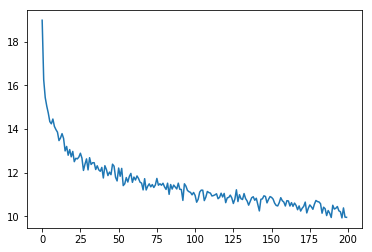

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)


In [14]:
max_length = MAX_LEN
def sample_from_nn(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            hidden, output = rnn(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = ids_tokens[topi.item()]
                output_name += letter
            input = inputTensor(letter)

        return output_name
    
def sample_from_nn_distr(start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            hidden, output = rnn(input[0], hidden)
            output_arr = output.numpy()[0]
            print(output_arr)
            token_id = np.random.choice(range(len(output_arr)), p = output_arr)
            letter = ids_tokens[token_id]
            output_name += letter    
            input = inputTensor(letter)

        return output_name



In [36]:

sample_from_nn('v')

'vinnie####e#####'

In [120]:
??nn.LogSoftmax

In [117]:
??np.random.choice